In [1]:
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Flatten, Reshape, Permute
from keras.layers import TimeDistributed, Conv2D, Dense, Dropout, Activation, LSTM, MaxPooling2D, GRU, ConvLSTM2D, Bidirectional
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:

#fourtySecondData = drive.CreateFile({'id': '1KZb0bzfF9dfX4aW0pLBnIGg50qnf_8Rk'})
eightSecondData = drive.CreateFile({'id': '1_cvG6wanYkyT5E2PXxIRTxTcQim7CVGq'})
eightSecondData.GetContentFile('DATA.tar')
!tar --extract --file DATA.tar

In [5]:
#Start
#Fourty Second Data
#train_data_path = 'NexmonData/train'
#test_data_path = 'NexmonData/validation'
#img_rows = 255
#Eight Second Data
train_data_path = 'NexmonShortData/train'
test_data_path = 'NexmonShortData/validation'
img_rows = 51
img_cols = 56
epochs = 30
batch_size = 30
num_of_train_samples = 930
num_of_test_samples = 720
convFilter1 = 128

input_shape = (img_rows, img_cols, 1)

#Image Generator
train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    color_mode='grayscale',
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(test_data_path,
                                                        color_mode='grayscale',
                                                        target_size=(img_rows, img_cols),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')


Found 930 images belonging to 5 classes.
Found 720 images belonging to 5 classes.


In [17]:
# Build model
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 input_shape=input_shape,
                 padding='valid',
                 activation='tanh',
                 strides=1))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.15))

model.add(Conv2D(filters=convFilter1,
                 kernel_size=(5,5),
                 padding='valid',
                 activation='tanh',
                 strides=1))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.15))

model.add(Reshape((convFilter1,-1)))
model.add(Permute((2,1)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(5, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list=[checkpoint]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 47, 52, 32)        832       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 26, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 23, 26, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 19, 22, 128)       102528    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 11, 128)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 9, 11, 128)        0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 128, 99)           0         
__________

In [0]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
#Train
history = model.fit_generator(train_generator,
                    steps_per_epoch=num_of_train_samples // batch_size,
                    epochs=epochs,
                    callbacks=callbacks_list,
                    validation_data=validation_generator,
                    validation_steps=num_of_test_samples // batch_size, 
                    shuffle='true')

Epoch 1/30
31/31 [==============================] - 20s 631ms/step - loss: 1.1585 - acc: 0.4183 - val_loss: 3.3009 - val_acc: 0.1847

Epoch 00001: val_acc improved from -inf to 0.18472, saving model to weights.best.hdf5
Epoch 2/30
31/31 [==============================] - 18s 565ms/step - loss: 0.7719 - acc: 0.6774 - val_loss: 3.1263 - val_acc: 0.4847

Epoch 00002: val_acc improved from 0.18472 to 0.48472, saving model to weights.best.hdf5
Epoch 3/30
31/31 [==============================] - 17s 562ms/step - loss: 0.1865 - acc: 0.9344 - val_loss: 3.9530 - val_acc: 0.4917

Epoch 00003: val_acc improved from 0.48472 to 0.49167, saving model to weights.best.hdf5
Epoch 4/30
31/31 [==============================] - 18s 565ms/step - loss: 0.1254 - acc: 0.9505 - val_loss: 4.4769 - val_acc: 0.5333

Epoch 00004: val_acc improved from 0.49167 to 0.53333, saving model to weights.best.hdf5
Epoch 5/30
31/31 [==============================] - 18s 568ms/step - loss: 0.0655 - acc: 0.9753 - val_loss: 3.7

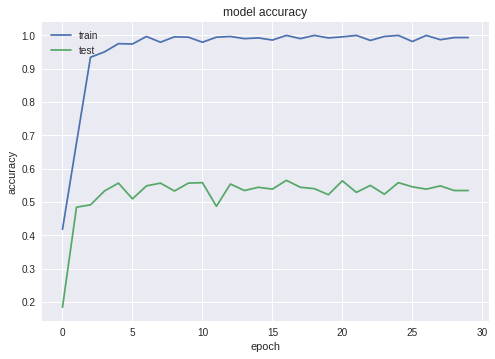

In [19]:
#History for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

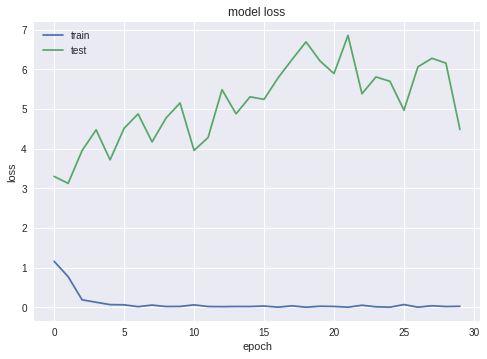

In [20]:
#History for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()